# Tweets sentiment analysis with RNN

Using GloVe for tweets word embedding and RNN for sentiment analysis

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import tensorflow as tf
import itertools as it
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import optuna
import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

SCRIPT_NAME = 'E-RNN-embeddings-v2'

In [2]:
class GloveEmbeddings:
    dict = None
    vocabulary = None
    word_index = None
    vocabulary_size = None
    embedding_dim = None
    UNKNOWN_TOKEN_INDEX = -1
    OUT_OF_VOCABULARY = '<OOV>'
    
    def __init__(self, dim=100, file_name='../glove.twitter.27B.100d.txt'):
        self.embedding_dim = dim
        self.dict = self.__load_glove_embeddings(file_name)
        if len(self.dict) == 0:
            raise Exception('Dictionary is empty')
        self.vocabulary = list(self.dict.keys())
        self.vocabulary_size = len(self.vocabulary)
        self.word_index = {} 
        self.UNKNOWN_TOKEN_INDEX = self.vocabulary_size + 1
        for index, word in enumerate(self.vocabulary):
            self.word_index[word]=index

    def word_to_token(self, word) -> int:
        index = self.word_index.get(word)
        if index == None:
            return self.UNKNOWN_TOKEN_INDEX
        return index + 1 # reserve value 0 for masking
    
    def token_to_word(self, token) -> str:
        if token == 0:
            return None
        index = token - 1
        word = self.vocabulary[index] if index < self.vocabulary_size else self.OUT_OF_VOCABULARY
        return word
    
    def __getitem__(self, key):
        return self.dict[key]

    def __load_glove_embeddings(self, path):
        embeddings_dict = {}
        with open(path, 'r', encoding='utf-8') as f:
            for line in f:
                values = line.split()
                word = values[0]
                vector = np.asarray(values[1:], "float32")
                if vector.shape[0] == self.embedding_dim:
                    embeddings_dict[word] = vector
        return embeddings_dict                


In [3]:
glove = GloveEmbeddings()

In [4]:
class Tokenizer:
    tokenizer = nltk.tokenize.TweetTokenizer()
    glove = None

    def __init__(self, glove: GloveEmbeddings):
        self.glove = glove

    def tokenize(self, sentence, skip_oov=True):
        """Tokenize a sentence. Returns a tuple of words and tokens (numerical IDs)"""
        words = self.tokenizer.tokenize(sentence.lower())
        tokens = [glove.word_to_token(w) for w in words]
        if skip_oov:
            tokens = [token for token in tokens if token != glove.UNKNOWN_TOKEN_INDEX]
        return words, tokens


def tokenize_tweets_example(tokenizer: Tokenizer):
    examples = [
        'Don''t you expect this? Check out 123 page at http://simple.com/site/page.html and #others fyi @fellow',
        'U.S National Park Services Tonto National Forest: Stop the Annihilation of the Salt River Wild Horse... http://t.co/KPQk0C4G0M via @Change',
    ]
    for sentence in examples:
        words, tokens = tokenizer.tokenize(sentence)
        print('words', words)
        print('tokens', tokens)


tokenizer = Tokenizer(glove)

tokenize_tweets_example(tokenizer)



words ['dont', 'you', 'expect', 'this', '?', 'check', 'out', '123', 'page', 'at', 'http://simple.com/site/page.html', 'and', '#others', 'fyi', '@fellow']
tokens [349, 16, 2338, 54, 15, 526, 100, 1738, 67, 27, 13054]
words ['u', '.', 's', 'national', 'park', 'services', 'tonto', 'national', 'forest', ':', 'stop', 'the', 'annihilation', 'of', 'the', 'salt', 'river', 'wild', 'horse', '...', 'http://t.co/kpqk0c4g0m', 'via', '@change']
tokens [52, 2, 138, 2584, 1691, 5694, 6543, 2584, 10051, 3, 362, 14, 223294, 40, 14, 9352, 3571, 2860, 4978, 202]


In [5]:
def build_glove_embedding_matrix(glove: GloveEmbeddings):
    num_tokens = glove.vocabulary_size + 2  # Adding 2 for padding and out-of-vocabulary tokens
    emb_dim = glove.embedding_dim
    embedding_matrix = np.zeros((num_tokens, emb_dim), dtype=np.float32)
    print('Matrix shape', embedding_matrix.shape)
    for word in glove.vocabulary:
        index = glove.word_to_token(word)
        vector = glove[word]
        embedding_matrix[index] = vector
    return embedding_matrix

In [6]:
embedding_matrix = build_glove_embedding_matrix(glove)

Matrix shape (1193515, 100)


In [7]:
EMBEDDING_DIM = glove.embedding_dim
VOCABULARY_SIZE = glove.vocabulary_size
MAX_SEQ_LEN = 50

print('Word embedding vector dim', EMBEDDING_DIM)
print('Vocabulary size', VOCABULARY_SIZE)
print('Max sequence len', MAX_SEQ_LEN)

Word embedding vector dim 100
Vocabulary size 1193513
Max sequence len 50


### Load and prepare train/validation data and find embeddings

In [8]:
df = pd.read_csv('train.csv')
X_raw = df['text'].fillna('')
Y = df['target']

In [9]:
def tokenize_input(X, tokenizer: Tokenizer, skip_oov=True, max_seq_len=MAX_SEQ_LEN):
    x_tokenized = np.zeros((X.size, max_seq_len), dtype=np.int32)

    for i, sentence in enumerate(X):
        _, tokens = tokenizer.tokenize(sentence, skip_oov=skip_oov)
        for j, token in enumerate(tokens[:max_seq_len]):            
            x_tokenized[i, j] = token

    return x_tokenized

def decode_tokens(tokens, glove: GloveEmbeddings) -> str:
    words = [glove.token_to_word(t) for t in tokens if t > 0]
    return ' '.join(words)

In [10]:
X_all_tokens = tokenize_input(X_raw, tokenizer, skip_oov=False)

# Check ratio of known tokens
all_items = np.sum(X_all_tokens > 0)
known_tokens = np.sum((X_all_tokens > 0) & (X_all_tokens < glove.UNKNOWN_TOKEN_INDEX))
unknown_tokens = np.sum(X_all_tokens == glove.UNKNOWN_TOKEN_INDEX)
print(f'All tokens: {all_items}, known tokens: {known_tokens}, unknown tokens: {unknown_tokens}, know ratio: {known_tokens/all_items:.3f}')

All tokens: 128539, known tokens: 109186, unknown tokens: 19353, know ratio: 0.849


In [11]:
X = tokenize_input(X_raw, tokenizer)

X[0,:20]

array([  278, 33409,    71,    14,   947,    40,    54,   531,   695,
        3837,   292,    76,     0,     0,     0,     0,     0,     0,
           0,     0], dtype=int32)

In [12]:
# Max # of tokens for a sentence
np.max(np.count_nonzero(X, axis=1))

47

### Cleanup Glove dictionary

In [13]:
# import gc

# del glove
# gc.collect()

### Split into train and validation data sets

In [14]:
indices = np.arange(X.shape[0])
X_train, X_dev, Y_train, Y_dev, idx_train, idx_test = train_test_split(X, Y, indices, test_size=0.1, shuffle=True)
X_raw_dev = X_dev.copy()
print(X_train.shape, Y_train.shape, X_dev.shape, Y_dev.shape)


(6851, 50) (6851,) (762, 50) (762,)


### Define model

In [15]:
def create_model(use_batch_norm=False, lstm_size=8, dense_size=8, dropout_1=0.5, dropout_2=0.5,
          learning_rate=1e-3):
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Embedding(input_dim=VOCABULARY_SIZE+2, output_dim=EMBEDDING_DIM, input_length=MAX_SEQ_LEN, 
                                      embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                      trainable=False, mask_zero=True))
    
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_size, dropout=dropout_1)))
    # model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_size, dropout=dropout_2)))
    
    if use_batch_norm:
      model.add(tf.keras.layers.BatchNormalization())
    else:
      model.add(tf.keras.layers.Dropout(dropout_1))   
    
    if use_batch_norm:
      model.add(tf.keras.layers.Dense(dense_size))
      model.add(tf.keras.layers.BatchNormalization())
      model.add(tf.keras.layers.Activation('relu'))
    else:
      model.add(tf.keras.layers.Dense(dense_size, activation='relu'))
      model.add(tf.keras.layers.Dropout(dropout_2))
    
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [16]:
def evaluate(X, Y, model):
    Y_predict = model.predict(X)
    Y_predict = (Y_predict > .5).astype(np.int8)
    f1_value = f1_score(Y, Y_predict)
    return Y_predict, f1_value


In [17]:
def train(X_train, Y_train, X_dev, Y_dev, model, batch_size=32, max_epochs=4):
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
    
    model.fit(X_train, Y_train, batch_size=batch_size, epochs=max_epochs, 
            validation_data=(X_dev, Y_dev),
            callbacks=[early_stopping],
            verbose=1)

    _, f1_value = evaluate(X_dev, Y_dev, model)    

    print(f"Validation F1 score: {f1_value}")

    return f1_value

### Check model

In [17]:
model = create_model(learning_rate=5e-3,lstm_size=8, dense_size=8)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           119351500 
                                                                 
 bidirectional (Bidirectiona  (None, 16)               6976      
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 8)                 136       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                        

In [18]:
X_train.shape, Y.shape, (MAX_SEQ_LEN, EMBEDDING_DIM)

((6851, 50), (7613,), (50, 100))

In [82]:
X_train = X_train.astype('int32')
Y_train = Y_train.astype('int32')
X_dev = X_dev.astype('int32')
Y_dev = Y_dev.astype('int32')

In [20]:
train(X_train, Y_train, X_dev, Y_dev, model, max_epochs=5)

Epoch 1/5
215/215 [==============================] - 15s 43ms/step - loss: 0.6331 - accuracy: 0.6342 - val_loss: 0.4985 - val_accuracy: 0.7848
Epoch 2/5
215/215 [==============================] - 7s 31ms/step - loss: 0.5403 - accuracy: 0.7449 - val_loss: 0.4708 - val_accuracy: 0.7979
Epoch 3/5
215/215 [==============================] - 7s 32ms/step - loss: 0.5283 - accuracy: 0.7485 - val_loss: 0.4686 - val_accuracy: 0.8005
Epoch 4/5
215/215 [==============================] - 7s 32ms/step - loss: 0.5180 - accuracy: 0.7545 - val_loss: 0.4676 - val_accuracy: 0.7953
Epoch 5/5
24/24 [==============================] - 2s 6ms/step
Validation F1 score: 0.7713004484304933


0.7713004484304933

### Hyper-parameters tuning

In [21]:
def objective(trial):
    print('Creating model')
    decay_steps = 100
    decay_rate = 0.9

    initial_learning_rate = trial.suggest_float('initial_learning_rate', 1e-3, 5e-3, log=True)
    batch_size = 32 # trial.suggest_categorical('batch_size', [32, 64, 128])
    lstm_size = trial.suggest_categorical('lstm_size', [4, 8, 16, 32])
    dense_size = trial.suggest_categorical('dense_size', [8, 16, 32, 64])
    use_dropout_1 = trial.suggest_categorical('use_dropout_1', [False, True])
    use_dropout_2 = trial.suggest_categorical('use_dropout_2', [False, True])
    if use_dropout_1:
        dropout_1 = trial.suggest_float('dropout_1', 0.1, 0.5)
    else:
        dropout_1 = 0
    if use_dropout_2:
        dropout_2 = trial.suggest_float('dropout_2', 0.1, 0.5)
    else:
        dropout_2 = 0

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=initial_learning_rate, 
                                                             decay_steps=decay_steps,
                                                             decay_rate=decay_rate)
    model = create_model(lstm_size=lstm_size, dense_size=dense_size,
                  dropout_1=dropout_1, dropout_2=dropout_2, 
                  learning_rate=lr_schedule)
    f1_score = train(X_train, Y_train, X_dev, Y_dev, model, 
                        batch_size=batch_size, max_epochs=10)
    
    print('train is done')
    # trial.set_user_attr("model", model)
    print('just before objective end')
    
    return f1_score


In [23]:
study = optuna.create_study(study_name=SCRIPT_NAME, direction='maximize')

[I 2024-05-08 17:03:06,649] A new study created in memory with name: E-RNN-embeddings-v2


In [24]:
study.optimize(objective, n_trials=10, show_progress_bar=True)

  0%|          | 0/10 [00:00<?, ?it/s]

Creating model
Epoch 1/10
215/215 [==============================] - 15s 42ms/step - loss: 0.6321 - accuracy: 0.6468 - val_loss: 0.5159 - val_accuracy: 0.7651
Epoch 2/10
215/215 [==============================] - 7s 32ms/step - loss: 0.5247 - accuracy: 0.7593 - val_loss: 0.4744 - val_accuracy: 0.7992
Epoch 3/10
215/215 [==============================] - 7s 31ms/step - loss: 0.5083 - accuracy: 0.7748 - val_loss: 0.4771 - val_accuracy: 0.8005
Epoch 4/10
215/215 [==============================] - 7s 33ms/step - loss: 0.4989 - accuracy: 0.7777 - val_loss: 0.4696 - val_accuracy: 0.7913
Epoch 5/10
215/215 [==============================] - 7s 33ms/step - loss: 0.4884 - accuracy: 0.7857 - val_loss: 0.4690 - val_accuracy: 0.7927
Epoch 6/10
215/215 [==============================] - 7s 33ms/step - loss: 0.4866 - accuracy: 0.7856 - val_loss: 0.4684 - val_accuracy: 0.7927
Epoch 7/10
215/215 [==============================] - 7s 33ms/step - loss: 0.4810 - accuracy: 0.7870 - val_loss: 0.4666 - val_

In [28]:
trial = study.best_trial
print(f'-> Best score: {trial.value}')
print(f'-> Optimal network parameters: ')
pprint.pprint(trial.params)
print(f'-> Best learning parameters: ')
pprint.pprint(trial.user_attrs)


-> Best score: 0.7805642633228839
-> Optimal network parameters: 
{'dense_size': 8,
 'dropout_1': 0.2530360774273983,
 'initial_learning_rate': 0.0010470517028874917,
 'lstm_size': 8,
 'use_dropout_1': True,
 'use_dropout_2': False}
-> Best learning parameters: 
{}


### Training with optimal hyper parameters

In [18]:
the_best_model = create_model(lstm_size=8, dense_size=8,
                dropout_1=0.25, dropout_2=0, 
                learning_rate=1e-3)
f1_value = train(X_train, Y_train, X_dev, Y_dev, the_best_model, batch_size=32, max_epochs=10)

Epoch 1/10
215/215 [==============================] - 35s 115ms/step - loss: 0.5997 - accuracy: 0.6862 - val_loss: 0.4880 - val_accuracy: 0.7769
Epoch 2/10
215/215 [==============================] - 16s 73ms/step - loss: 0.4959 - accuracy: 0.7730 - val_loss: 0.4518 - val_accuracy: 0.7992
Epoch 3/10
215/215 [==============================] - 17s 77ms/step - loss: 0.4671 - accuracy: 0.7910 - val_loss: 0.4584 - val_accuracy: 0.7769
Epoch 4/10
215/215 [==============================] - 15s 67ms/step - loss: 0.4515 - accuracy: 0.7971 - val_loss: 0.4277 - val_accuracy: 0.8163
Epoch 5/10
215/215 [==============================] - 13s 59ms/step - loss: 0.4410 - accuracy: 0.8065 - val_loss: 0.4288 - val_accuracy: 0.8163
Epoch 6/10
215/215 [==============================] - 12s 56ms/step - loss: 0.4366 - accuracy: 0.8053 - val_loss: 0.4192 - val_accuracy: 0.8228
Epoch 7/10
215/215 [==============================] - 12s 57ms/step - loss: 0.4221 - accuracy: 0.8145 - val_loss: 0.4194 - val_accuracy

### Evaluate predication on validation data

In [19]:
def evaluate_final_results(X, Y, Y_pred):
    # Compute the confusion matrix
    cm = confusion_matrix(Y, Y_pred)

    # Compute other metrics
    accuracy = accuracy_score(Y, Y_pred)
    precision = precision_score(Y, Y_pred, average='macro')
    recall = recall_score(Y, Y_pred, average='macro')
    f1 = f1_score(Y, Y_pred, average='macro')

    # Print the metrics
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

    # Plot the confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()    

24/24 [==============================] - 0s 3ms/step
Accuracy: 0.8228346456692913
Precision: 0.8229220779220779
Recall: 0.8141790154221975
F1 Score: 0.8172678100381026


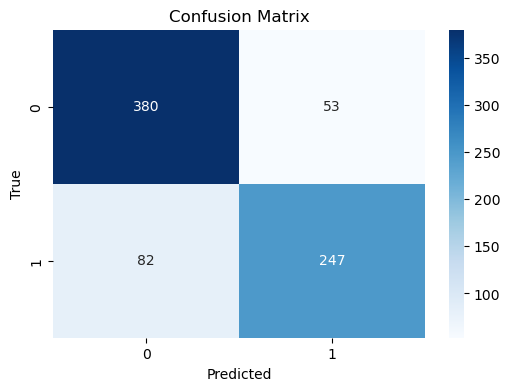

In [20]:
Y_predict, f1_value = evaluate(X_dev, Y_dev, the_best_model)
evaluate_final_results(X_dev, Y_dev, Y_predict)

### Error analysis

In [21]:
X_raw_dev.shape

(762, 50)

In [28]:
print(X_raw_dev[0])
print(decode_tokens(X_raw_dev[0], glove))
print(X_raw.iloc[idx_test[0]])

[   194  23317     94     30  16465      2     80     59 197632    412
     27 372151    398     12   3337     67 662820    235   9536     11
    856 372151      2     89    665      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0]
oh gio was my backup . but with skc next and bwp getting a crack at nycfc + injury i went bwp . lol wrong
@JJ_DIRTY @MLSTransfers @greggmair oh Gio was my backup. But with SKC next and BWP getting a crack at NYCFC + injury I went BWP. Lol wrong


In [34]:
decoded_sentences = np.apply_along_axis(lambda tokens: decode_tokens(tokens, glove), axis=1, arr=X_raw_dev)
original_sentences = np.apply_along_axis(lambda idx: X_raw.iloc[idx], axis=0, arr=idx_test)
result = pd.DataFrame(np.column_stack((original_sentences, decoded_sentences, Y_dev, Y_predict)), columns=['text', 'decoded', 'y', 'y_pred'])
result = result.query('y != y_pred')


In [38]:
pd.set_option('display.max_colwidth', 150)
result.sample(n=10)

,text,decoded,y,y_pred
562,ChinaÛªs stock market crash this summer has sparked interest from bargain hunters and bulls betting on a rebound. DÛ_ http://t.co/1yggZziZ9o,china stock market crash this summer has sparked interest from bargain hunters and bulls betting on a reb,0,1
742,Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE,who is bringing the tornadoes and floods . who is bringing the climate change . god is after america he i,0,1
135,Offers : http://t.co/Gl3C1vc88P #8392 Deluxe Toilet Safety Support/Health/Home/Bathroom/Support/Elderly/Injured/SÛ_ http://t.co/vihdoKScCC,offers : deluxe toilet safety support / health / home / bathroom / support / elderly / injured / s,1,0
290,HereÛªs how media in Pakistan covered the capture of terrorist Mohammed Naved http://t.co/f7WqpCEkg2,here how media in pakistan covered the capture of terrorist mohammed,0,1
544,Swansea Û÷plot hijack transfer move for Southampton target Virgil van DijkÛª http://t.co/PVmr38LnvA,swansea û ÷ plot hijack transfer move for southampton target virgil van dijk,1,0
268,my dad said I look thinner than usual but really im over here like http://t.co/bnwyGx6luh,my dad said i look thinner than usual but really im over here like,1,0
760,'There was a small earthquake in LA but don't worry Emmy Rossum is fine',' there was a small earthquake in la but worry emmy rossum is fine ',1,0
636,@YoungHeroesID LAVA BLAST dan POWER RED #PantherAttack @Mirmanda11 @evaaaSR,lava blast dan power red,1,0
264,I can't drown my demons they know how to swim,i drown my demons they know how to swim,1,0
592,'I came to kill Indians...for FUN': Video of smirking and remorseless Pakistani killer shows him boasting. http://t.co/FPjLwOXKlg,' i came to kill indians for fun ' : video of smirking and pakistani killer shows him boasting .,1,0


### Generate submission

In [41]:
def generate_submission(model):
    df_test = pd.read_csv('./test.csv', index_col='id')
    df_test.fillna({'text': '', 'keyword': '', 'location': ''}, inplace=True)
    X_raw_test = df_test['text'].to_numpy()
    X_test = tokenize_input(X_raw_test, tokenizer)

    Y_test_predict = model(X_test)
    Y_test_predict = tf.cast(Y_test_predict > .5, tf.int32)

    df_example = pd.read_csv('./sample_submission.csv')
    df_example['target'] = Y_test_predict

    df_example.to_csv(f'./{SCRIPT_NAME}-submission.csv', index=False)


In [42]:
generate_submission(the_best_model)